In [1]:
import sys, os
import numpy as np
sys.path.append('../src/')
import torch
from mgnn.MolGraphNetwork import MolGraphNetwork
from utils import find_repo_root
from scf_guess_tools import Backend
from scf_guess_datasets import Qm9Isomeres

project_root_dir = find_repo_root()
print("Project root directory:", project_root_dir)
BASIS_PATH = "../../../scripts/6-31g_2df_p_custom_nwchem.gbs"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
#Current best trial: ebffc_00023 with loss=3.290987253189087 and params={'batch_size': 16, 'hidden_dim': 512, 'message_passing_steps': 6, 'edge_threshold_val': 1., 'message_net_dropout': 0.09772288864576731, 'dat5122788896881607a_aug_factor': 1.0, 'message_net_layers': 5, 'lr': 0.0003257920597967229, 'weight_decay': 3.460137919135933e-06, 'num_epochs': 50, 'grace_epochs': 5, 'lr_factor': 0.5, 'lr_patience': 3, 'lr_threshold': 0.001, 'lr_cooldown': 2, 'lr_min': 1e-06}




Project root directory: /home/etschgi1/REPOS/Masterarbeit
Using device: cpu


In [2]:
local_pc_path = os.path.join(project_root_dir, "datasets/QM9")
dataset = Qm9Isomeres(
    local_pc_path, 
    size = 500, # number of molecules to load
    val=0.1, # using 80% training / 10 % val / 10% test split
    test=0.1
)


In [3]:
MGNN = MolGraphNetwork(dataset=dataset,
                       basis=BASIS_PATH,
                       backend=Backend.PY,
                       batch_size=16,
                       hidden_dim=256,
                       message_passing_steps=4,
                       edge_threshold_val=3,
                       message_net_layers=3,
                       message_net_dropout=0.15,
                       target="density",
                       data_aug_factor=1,
                       verbose_level=2)
MGNN.load_data()

Setting verbose level to: 2
Loading 500 files from qm9_isomeres...
Loading 400 files for train set from /home/etschgi1/REPOS/Masterarbeit/scf_guess_datasets/scf_guess_datasets/qm9_isomeres/xyz...
Loading 50 files for val set from /home/etschgi1/REPOS/Masterarbeit/scf_guess_datasets/scf_guess_datasets/qm9_isomeres/xyz...
Loading 50 files for test set from /home/etschgi1/REPOS/Masterarbeit/scf_guess_datasets/scf_guess_datasets/qm9_isomeres/xyz...


Creating training graphs: 400it [00:01, 284.38it/s]
Creating validation graphs: 50it [00:00, 277.15it/s]
Creating test graphs: 50it [00:00, 264.05it/s]


Total samples: 500, Train: 400, Val: 50, Test: 50
Found 3 center keys (['C', 'H', 'O']) and 6 edge keys (['C_C', 'C_H', 'C_O', 'H_H', 'H_O', 'O_O']) in the training set. -> Totaling 9 unique encoder/decoder.
Normalization factors computed and applied.
Center stats: {'C': (0.08893045239638739, 0.2721039375810204), 'H': (0.3772194703420003, 0.4689655636092979), 'O': (0.08820201116919178, 0.2707920626400333)}, Edge stats: {'C_C': (0.0011760330437032402, 0.06722017499561404), 'C_H': (0.006002088116921686, 0.08899061742111722), 'C_O': (0.0006347355153139232, 0.05741605368722725), 'H_H': (0.014465763551363572, 0.05865220878540266), 'H_O': (0.0024979208887975805, 0.05124095921518987), 'O_O': (-0.000207575137635023, 0.02002456199551411)}
First train batch: 304 atoms, 2634 edges, 304 center blocks.
Found center block size 351 for atom type C.
Found center block size 351 for atom type O.
Found center block size 15 for atom type H.
Found edge block size 676 for edge type C_C.
Found edge block siz

In [5]:
RETRAIN = False  
model_name = "MGNN_6-31G_NO_AUG_07_07_manual_ref"
if not RETRAIN and os.path.exists(f"{project_root_dir}/3_studies/Block_guessing/models/{model_name}.pth"):
    MGNN.load_model(f"{project_root_dir}/3_studies/Block_guessing/models/{model_name}.pth")
else:
    MGNN.train_model(num_epochs=100, lr=0.00268, weight_decay=1.78e-5, grace_epochs=10, model_save_path=f"{project_root_dir}/3_studies/Block_guessing/models/{model_name}.pth", loss_on_full_matrix=False)
    MGNN.save_model(f"{project_root_dir}/3_studies/Block_guessing/models/{model_name}.pth")

Loaded weights from /home/etschgi1/REPOS/Masterarbeit/3_studies/Block_guessing/models/MGNN_6-31G_NO_AUG_07_07_manual_ref.pth (strict=True)


/home/etschgi1/REPOS/Masterarbeit/3_studies/mgnn/MolGraphNetwork.py:1024: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=lambda sto

In [6]:
import pickle
from matplotlib import pyplot as plt
with open(f"{project_root_dir}/3_studies/Block_guessing/models/{model_name}.history", "rb") as f: 
    hist = pickle.load(f)
# hist["train_loss"]
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(hist["train_loss"], label="Training Loss", color="tab:blue")
ax.plot(hist["val_loss"], label="Validation Loss", color="tab:orange")
ax.plot(np.array(hist["val_loss"]).argmin(), hist["val_loss"][np.array(hist["val_loss"]).argmin()],
         marker="o", markersize=5, color="tab:orange", label="Best Validation Loss")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_yscale("log")
ax2 = ax.twinx()
ax2.plot(hist["lr"], linestyle="--", label="learning rate")
ax2.set_ylabel("Learning Rate")
ax2.tick_params(axis='y')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc="upper right")
plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/home/etschgi1/REPOS/Masterarbeit/3_studies/Block_guessing/models/MGNN_6-31G_NO_AUG_07_07_manual_ref.history'

In [7]:
test_graphs = MGNN.get_graphs("test")

Testing on random sample with id 49


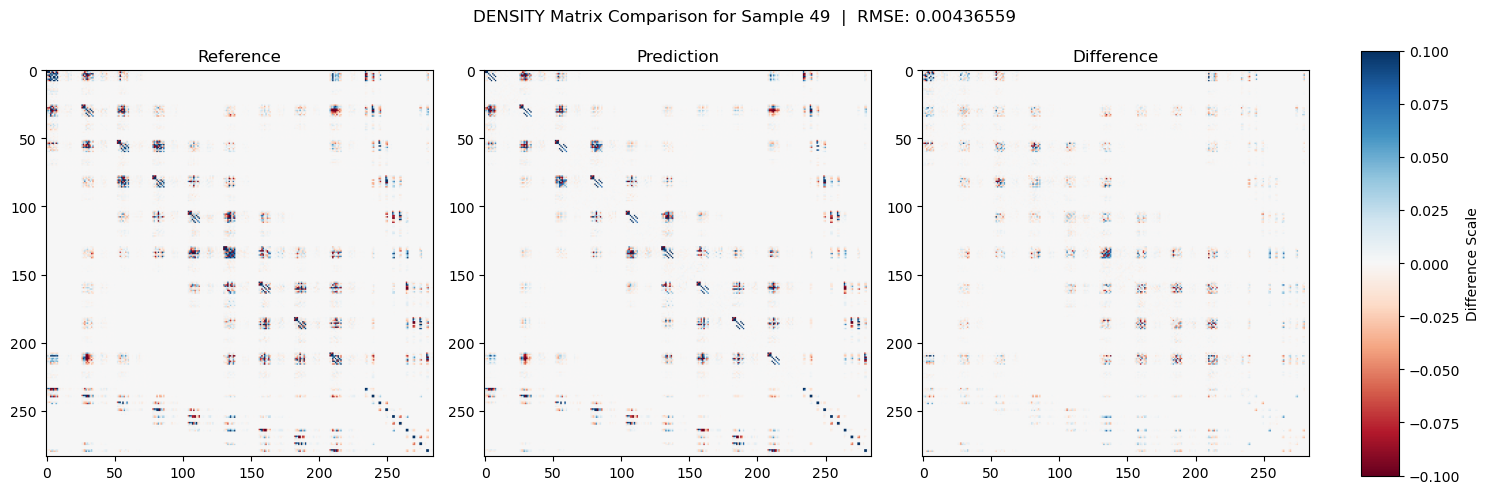

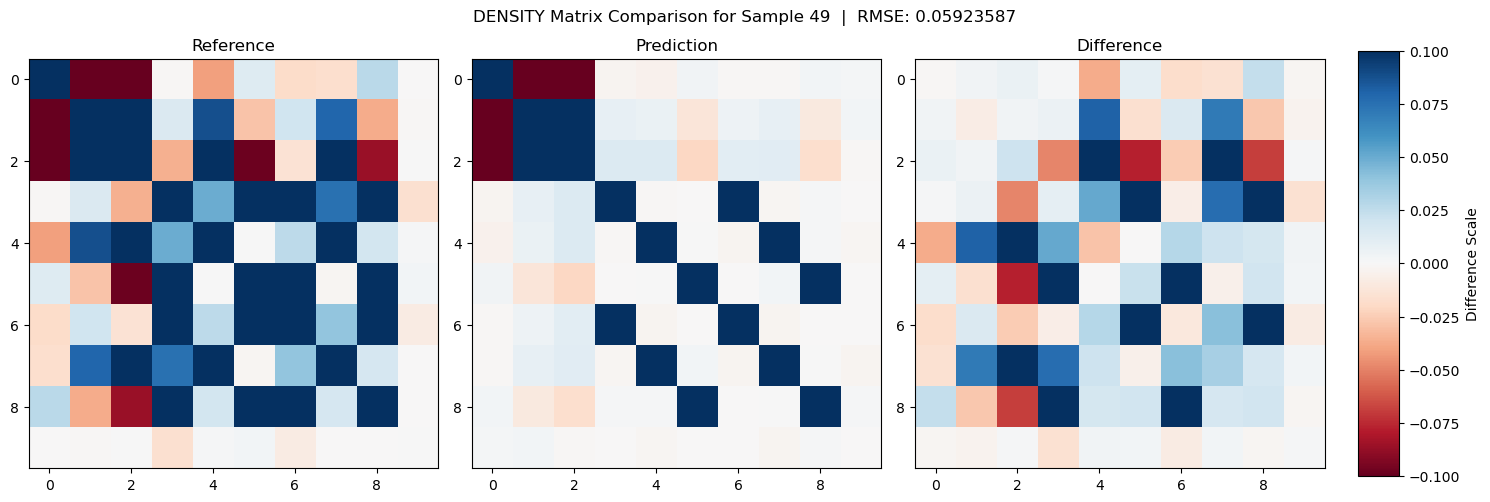

In [11]:
# aux code for testing
sys.path.append('../../')
from utils import plot_mat_comp

randsample_id = np.random.randint(0, len(test_graphs))
print(f"Testing on random sample with id {randsample_id}")
test_graph = test_graphs[randsample_id]
density_pred, density_truth = MGNN.predict([test_graph], include_target=True, transform_to_density=True)[0]
plot_mat_comp(density_truth,density_pred, 
                     title=f"DENSITY Matrix Comparison for Sample {randsample_id}", vmax=0.1)
plot_mat_comp( density_truth[:10,:10],density_pred[:10,:10], 
                     title=f"DENSITY Matrix Comparison for Sample {randsample_id}", vmax=0.1)

In [12]:
from time import time
from uncertainties import ufloat
import scf_guess_datasets

In [13]:
start_time = time()
density_preds = MGNN.predict(test_graphs, include_target=False, transform_to_density=True)

pred_time = time() - start_time # stat benchmarking later
print(f"Prediction time for {len(test_graphs)} samples: {pred_time:.2f} seconds - {pred_time/len(test_graphs):.4f} seconds per sample")

files = MGNN.get_files("test")
print(f"Number of test files: {len(files)}")

cycles =  []
print("Testing for iteration count")

Prediction time for 50 samples: 1.16 seconds - 0.0232 seconds per sample
Number of test files: 50
Testing for iteration count


# Trace check

In [34]:
print(np.mean([x.trace() for x in density_preds]))
pred = MGNN.predict(test_graphs, include_target=True, transform_to_density=True)
sol_densities = [x[1] for x in pred]
print(np.mean([x.trace() for x in sol_densities]))


44.274417750211434
44.19250457892194


# Iteration Benchmark

In [14]:
# own 
test_keys = dataset.test_keys # only use half of the validation set -> which is the test set used by the model!
for i, density_pred in enumerate(density_preds):
    solver = dataset.solver(test_keys[i])
    overlap, hcore, density, fock, status = scf_guess_datasets.solve(solver, density_pred.astype(np.float64))
    cycles.append(status.iterations)
    print(f"Sample {i}: Cycles with own guess: {status.iterations}")


Sample 0: Cycles with own guess: 12
Sample 1: Cycles with own guess: 11


KeyboardInterrupt: 

# Iterations benchmark

In [ ]:
mean_own = np.mean(cycles)
std_own = np.std(cycles)
iter_own = ufloat(mean_own, std_own)
print(f"Average iterations with own guess: {iter_own:.2f}")
with open(f"{project_root_dir}/3_studies/Block_guessing/models/{model_name}_cycles.pkl", "wb") as f:
    pickle.dump(cycles, f)

Average iterations with own guess: 11.20+/-0.49


In [ ]:
scheme_iterations = {dataset.schemes[i]: [] for i in range(len(dataset.schemes))}
for key in dataset.test_keys: #! only use half of the validation set -> which is the test set used by the model!
    for scheme, sample in dataset.guesses(key).items():
        scheme_iterations[scheme].append(sample.status.iterations)
for scheme, iterations in scheme_iterations.items():
    print(f"{scheme}: {np.mean(iterations):.2f} +- {np.std(iterations):.2f} iterations")

1e: 18.80 +- 1.82 iterations
vsap: 14.18 +- 0.93 iterations
sap: 16.56 +- 1.90 iterations
minao: 10.76 +- 0.59 iterations


# Energy benchmark

In [15]:
from pyscf import gto, dft

def create_mf_from_mol(mol: gto.Mole, xc: str = "b3lyp") -> dft.RKS:
    mf = dft.RKS(mol)
    mf.xc = xc
    mf.grids.build()  # ensures XC grid is initialized
    return mf

def build_fock_from_density(mf: dft.RKS, density):
    vj, vk = mf.get_jk(dm=density)
    vxc = mf.get_veff(mf.mol, dm=density)
    hcore = mf.get_hcore()
    return hcore + vj + vxc - 0.5 * vk
def energy_elec(fock, density, coreH): 
    return np.trace((fock+hcore) @ density)

def energy_err(e_pred, e_conv): 
    return e_conv - e_pred, e_pred/e_conv -1

In [16]:
from scf_guess_datasets import solve
# sanity check
sample_key = 451
sample_from_ds = dataset.solution(sample_key)

xyz_base = "/home/ewachmann/REPOS/Masterarbeit/scf_guess_datasets/scf_guess_datasets/qm9_isomeres/xyz/dsC7O2H10nsd_"
key_str = f"0{sample_key}.xyz"
mol = load(xyz_base + key_str, basis=BASIS_PATH, backend=Backend.PY, symmetry=False)
sol_sample = calculate(mol, basis=BASIS_PATH, method="dft", functional="b3lypg", guess="minao")
new_res = solve(dataset.solver(sample_key), None)


NameError: name 'load' is not defined

In [ ]:
print(dataset.names[sample_key])
print(MGNN.get_files("test")[sample_key - 450])

dsC7O2H10nsd_3178
/home/ewachmann/REPOS/Masterarbeit/scf_guess_datasets/scf_guess_datasets/qm9_isomeres/xyz/dsC7O2H10nsd_3178.xyz


In [18]:
mf = create_mf_from_mol(mol.native, xc="b3lypg")
pred_density = MGNN.predict([test_graphs[1]], include_target=False, transform_to_density=True)[0]
fock_sample_pred = build_fock_from_density(mf, pred_density)

NameError: name 'mol' is not defined

In [19]:
# build all fock matrices
pred_focks = []
pred_overlaps = []
for i, pred_density in enumerate(density_preds):
    mol_file = xyz_base + f"0{i+450}.xyz"
    cur_mol = load(mol_file, basis=BASIS_PATH, backend=Backend.PY, symmetry=False).native
    mf = create_mf_from_mol(cur_mol, xc="b3lypg")
    pred_focks.append(build_fock_from_density(mf, pred_density))
    pred_overlaps.append(mf.get_ovlp())
    print(i)

FileNotFoundError: [Errno 2] No such file or directory: '/home/ewachmann/REPOS/Masterarbeit/scf_guess_datasets/scf_guess_datasets/qm9_isomeres/xyz/dsC7O2H10nsd_0450.xyz'

In [ ]:
# print(new_res[-1])
# again = solve(dataset.solver(451), new_res[2])
# print(again[-1])
# energy_elec(new_res[3], new_res[2], new_res[1])

Status(converged=True, iterations=11)
Status(converged=True, iterations=3)


-245.46267038113365

In [ ]:
# # pyscf raw
# mol = gto.Mole()
# mol.atom = xyz_base + key_str
# mol.basis = BASIS_PATH
# mol.charge = 0
# mol.spin = 0
# mol.symmetry = False
# # mol.cart = False
# mol.build()

# mf = scf.RKS(mol)
# mf.xc = "b3lypg"
# mf.init_guess = "minao"
# mf.kernel()
# density_pyscf = mf.make_rdm1()

converged SCF energy = -423.104475963713


In [ ]:
# plot_mat_comp(sol_sample.density().numpy, sample_from_ds.density, title=f"DENSITY Matrix Comparison for Sample {key_str}", vmax=0.1, ref_title="Recalc using minao & scf_guess_tools", pred_title="solution from dataset.solution(451)")
# plot_mat_comp(density_pyscf, sample_from_ds.density, title=f"DENSITY Matrix Comparison for Sample {key_str}", vmax=0.1, ref_title="Recalc using pyscf internal", pred_title="solution from dataset.solution(451)")
# plot_mat_comp(density_pyscf, sol_sample.density().numpy, title=f"DENSITY Matrix Comparison for Sample {key_str}", vmax=0.1, ref_title="Recalc using pyscf internal", pred_title="Recalc using minao & scf_guess_tools")

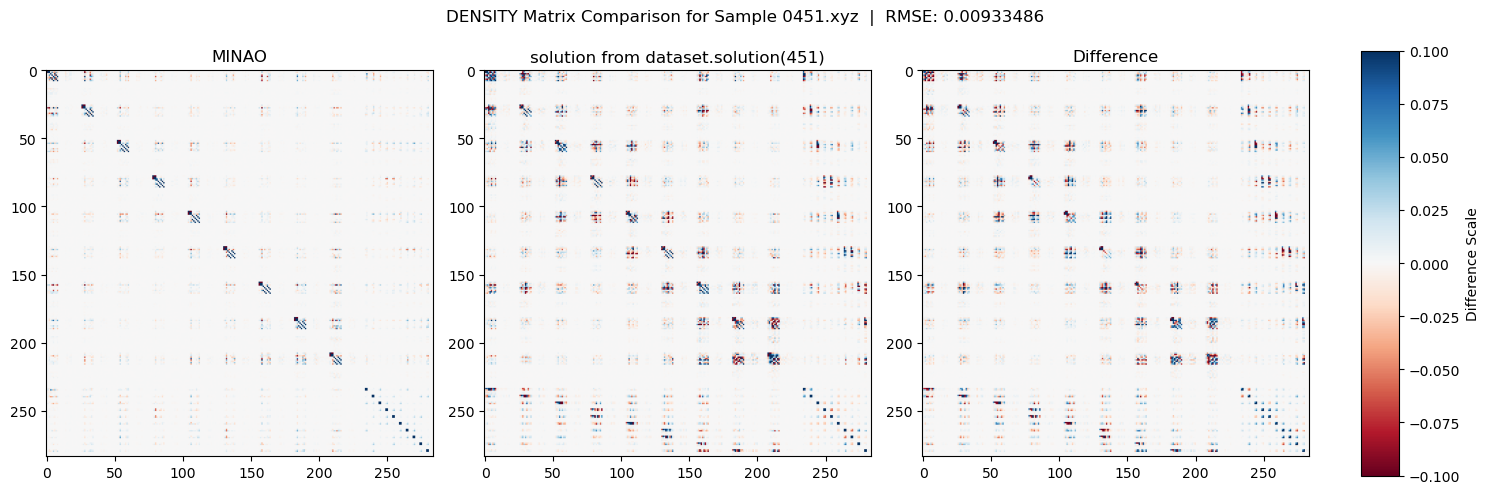

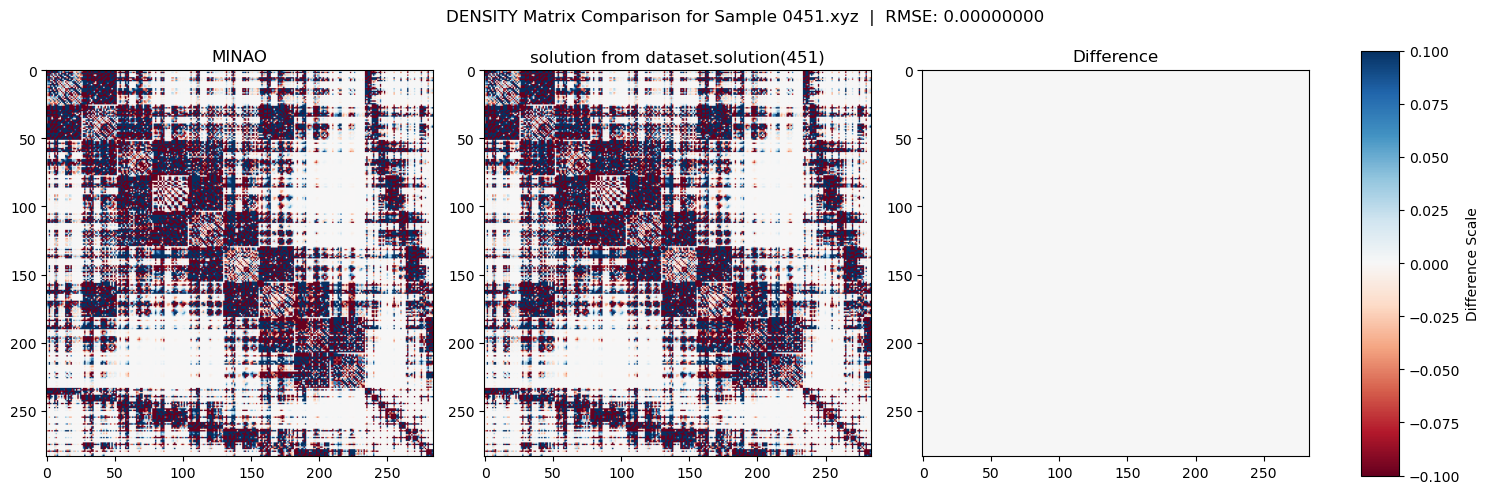

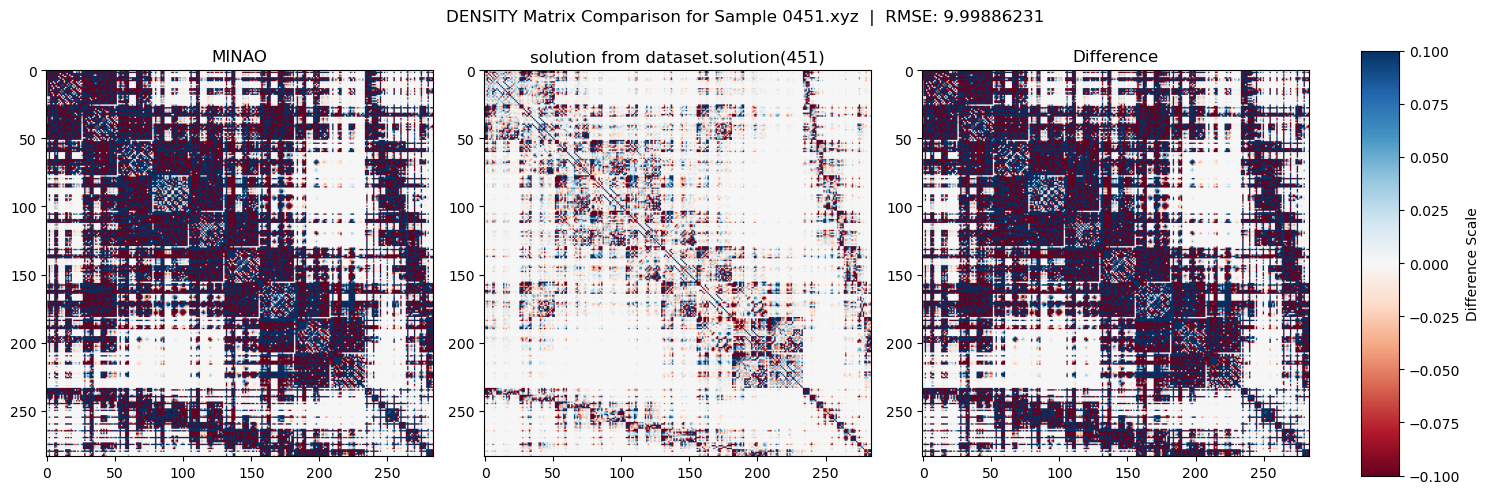

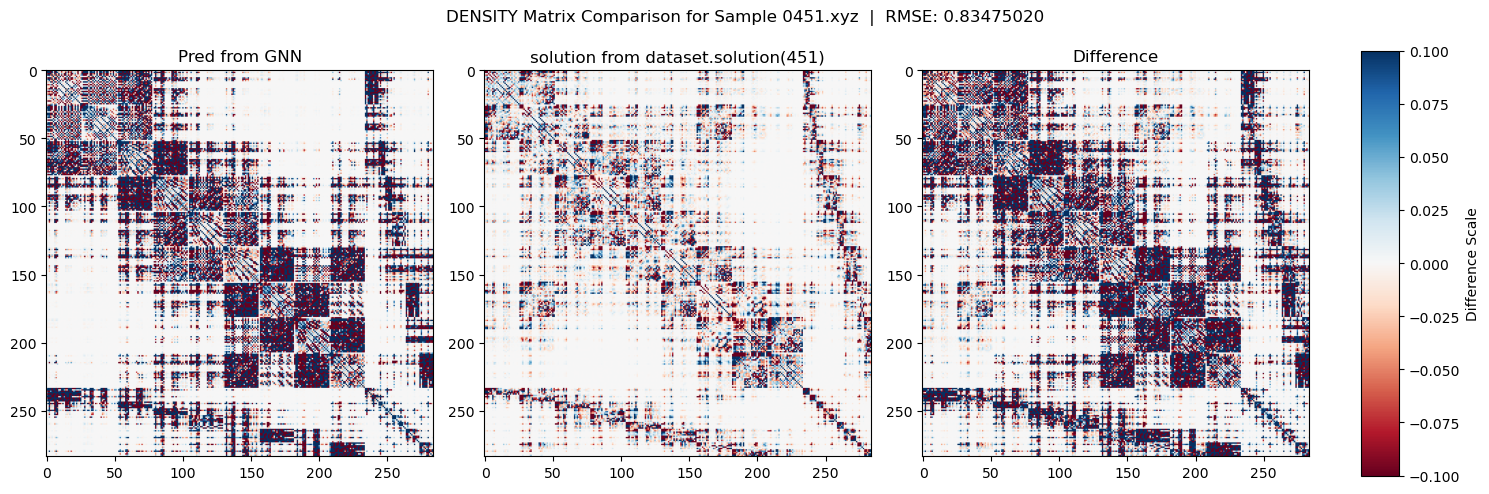

56913.40299803702
-75.63003780406966


In [ ]:
plot_mat_comp(dataset.guesses(sample_key)["minao"].density, sample_from_ds.density, title=f"DENSITY Matrix Comparison for Sample {key_str}", vmax=0.1, ref_title="MINAO", pred_title="solution from dataset.solution(451)")
plot_mat_comp(dataset.guesses(sample_key)["minao"].hcore, sample_from_ds.hcore, title=f"DENSITY Matrix Comparison for Sample {key_str}", vmax=0.1, ref_title="MINAO", pred_title="solution from dataset.solution(451)")
plot_mat_comp(dataset.guesses(sample_key)["minao"].fock, sample_from_ds.fock, title=f"DENSITY Matrix Comparison for Sample {key_str}", vmax=0.1, ref_title="MINAO", pred_title="solution from dataset.solution(451)")
plot_mat_comp(fock_sample_pred, sample_from_ds.fock, title=f"DENSITY Matrix Comparison for Sample {key_str}", vmax=0.1, ref_title="Pred from GNN", pred_title="solution from dataset.solution(451)")
print(dataset.guesses(sample_key)["minao"].fock.sum())
print(sample_from_ds.fock.sum())

Energy error is expected to be very high if one compares this to conv sol!

In [20]:
# dummy model
densities, focks, overlaps = [], [], []
for key in dataset.train_keys: 
    sample = dataset.solution(key)
    densities.append(sample.density)
    focks.append(sample.fock)
    overlaps.append(sample.overlap)
dummy_densities = np.mean(np.array(densities), axis=0)
dummy_focks = np.mean(np.array(focks), axis=0)
dummy_overlaps = np.mean(np.array(overlaps), axis=0)

In [21]:
energy_metrics = {dataset.schemes[i]: {"energy_conv":[], "energy_guess":[], "abs_err":[], "rel_err":[]} for i in range(len(dataset.schemes))}
energy_metrics["own"] = {"energy_conv":[], "energy_guess":[], "abs_err":[], "rel_err":[]}
energy_metrics["dummy"] = {"energy_conv":[], "energy_guess":[], "abs_err":[], "rel_err":[]}
for own, key in zip((density_preds, pred_focks), dataset.test_keys): #! only use half of the validation set -> which is the test set used by the model!
    energy_conv = energy_elec(dataset.solution(key).fock, dataset.solution(key).density, dataset.solution(key).hcore)
    for scheme, sample in dataset.guesses(key).items():
        e_pred = energy_elec(sample.fock, sample.density, sample.hcore)
        err, rel_err = energy_err(e_pred, energy_conv)
        energy_metrics[scheme]["abs_err"].append(err)
        energy_metrics[scheme]["rel_err"].append(rel_err)
        energy_metrics[scheme]["energy_conv"].append(energy_conv)
        energy_metrics[scheme]["energy_guess"].append(e_pred)
    # own
    # e_pred = energy_elec(own[1], own[0], sample.hcore)
    # err, rel_err = energy_err(e_pred, energy_conv)
    # energy_metrics["own"]["abs_err"].append(err)
    # energy_metrics["own"]["rel_err"].append(rel_err)
    # energy_metrics["own"]["energy_conv"].append(energy_conv)
    # energy_metrics["own"]["energy_guess"].append(e_pred)
    # 0D
    e_pred = energy_elec(dummy_focks, dummy_densities, sample.hcore)
    err, rel_err = energy_err(e_pred, energy_conv)
    energy_metrics["dummy"]["abs_err"].append(err)
    energy_metrics["dummy"]["rel_err"].append(rel_err)
    energy_metrics["dummy"]["energy_conv"].append(energy_conv)
    energy_metrics["dummy"]["energy_guess"].append(e_pred)



for scheme, metrics in energy_metrics.items():
    abs_err = np.mean(metrics["abs_err"])
    rel_err = np.mean(metrics["rel_err"])
    print(scheme)
    print(f"{abs_err:.4f} +- {np.std(metrics['abs_err']):.4f}")
    print(f"{rel_err:.4f} +- {np.std(metrics['rel_err']):.4f}")
    # print(f"{scheme}: Mean Absolute Error: {abs_err:.6f}, Mean Relative Error: {rel_err:.6f}")
    # print(f"Energy Conv: {np.mean(metrics['energy_conv']):.6f}, Energy Guess: {np.mean(metrics['energy_guess']):.6f}")

1e
552.5875 +- 739.0779
0.3738 +- 0.4809
vsap
9.2797 +- 14.6749
0.0064 +- 0.0095
sap
20.3470 +- 41.7183
0.0144 +- 0.0267
minao
123.4841 +- 120.7203
0.0816 +- 0.0800
own
nan +- nan
nan +- nan
dummy
-98.2323 +- 114.4813
-0.0557 +- 0.0665


/home/etschgi1/miniconda3/envs/scf_guess_1_0/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/etschgi1/miniconda3/envs/scf_guess_1_0/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/etschgi1/miniconda3/envs/scf_guess_1_0/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etschgi1/miniconda3/envs/scf_guess_1_0/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/etschgi1/miniconda3/envs/scf_guess_1_0/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret 

# DIIS Error

In [22]:
def diis_rmse(overlap, density, fock): 
    """Eq 2.3 - Milacher"""
    E = fock @ density @ overlap - overlap @ density @ fock
    diis_rmse_ = np.sqrt(np.linalg.norm(E, ord='fro')**2 / (density.shape[0]**2))
    return diis_rmse_

In [24]:
diis_metrics = {
    scheme: [] for scheme in dataset.schemes
}
diis_metrics["own"] = []  # for the own guess
diis_metrics["dummy"] = []  # for the dummy guess
diis_metrics["conv"] = []  # for the converged solution

for key in dataset.test_keys:  # only test split
    conv_diis = diis_rmse(dataset.solution(key).overlap, dataset.solution(key).density, dataset.solution(key).fock)
    diis_metrics["conv"].append(conv_diis)
    guesses = dataset.guesses(key)
    for scheme, sample in guesses.items():
        val = diis_rmse(sample.overlap, sample.density, sample.fock)
        diis_metrics[scheme].append(val)
    # own
    # own_diis = diis_rmse(pred_overlaps[key - 450], density_preds[key - 450], pred_focks[key - 450])
    # diis_metrics["own"].append(own_diis)
    # 0D
    dummy_diis = diis_rmse(dummy_overlaps, dummy_densities, dummy_focks)
    diis_metrics["dummy"].append(dummy_diis)


for scheme, values in diis_metrics.items():
    print(f"{scheme}: Mean DIIS RMSE: {np.mean(values):.10f} {np.std(values):.10f}")
    print(np.median(values))

1e: Mean DIIS RMSE: 0.1220736410 0.0102909119
0.12236101653510154
vsap: Mean DIIS RMSE: 0.0256453193 0.0020032135
0.025752338494939207
sap: Mean DIIS RMSE: 0.0438207363 0.0075270258
0.04267487692235404
minao: Mean DIIS RMSE: 0.0773358729 0.0026760638
0.07677069137489118
own: Mean DIIS RMSE: nan nan
nan
dummy: Mean DIIS RMSE: 0.0114794713 0.0000000000
0.011479471297565363
conv: Mean DIIS RMSE: 0.0000001570 0.0000000780
1.4361191860971766e-07


# RMSE

In [25]:
rmse_metric = {
    scheme: [] for scheme in dataset.schemes
}
rmse_metric["own"] = []  # for the own guess
rmse_metric["dummy"] = []  # for the dummy guess

for key in dataset.test_keys:
    for scheme, sample in dataset.guesses(key).items():
        val = np.sqrt(np.mean((sample.density - dataset.solution(key).density)**2))
        rmse_metric[scheme].append(val)
    # own
    # own_rmse = np.sqrt(np.mean((density_preds[key - 450] - dataset.solution(key).density)**2))
    # rmse_metric["own"].append(own_rmse)
    # 0D
    dummy_rmse = np.sqrt(np.mean((dummy_densities - dataset.solution(key).density)**2))
    rmse_metric["dummy"].append(dummy_rmse)

for scheme, values in rmse_metric.items():
    print(f"{scheme}: Mean RMSE: {np.mean(values):.5f} {np.std(values):.5f}")


1e: Mean RMSE: 0.14231 0.04107
vsap: Mean RMSE: 0.01086 0.00065
sap: Mean RMSE: 0.01598 0.00194
minao: Mean RMSE: 0.01550 0.00035
own: Mean RMSE: nan nan
dummy: Mean RMSE: 0.01375 0.00040


# One SCF step before benchmark

In [45]:
from scipy.linalg import eigh
def check_positive_definite(S, tol=1e-10):
    eigvals = np.linalg.eigvalsh(S)
    is_pd = np.all(eigvals > tol)
    return is_pd
def density_from_fock(fock, overlap, nocc):
    assert check_positive_definite(overlap)
    _, C = eigh(fock, overlap)
    C_occ = C[:, :nocc]
    density = 2 * C_occ @ C_occ.T 
    return density

450


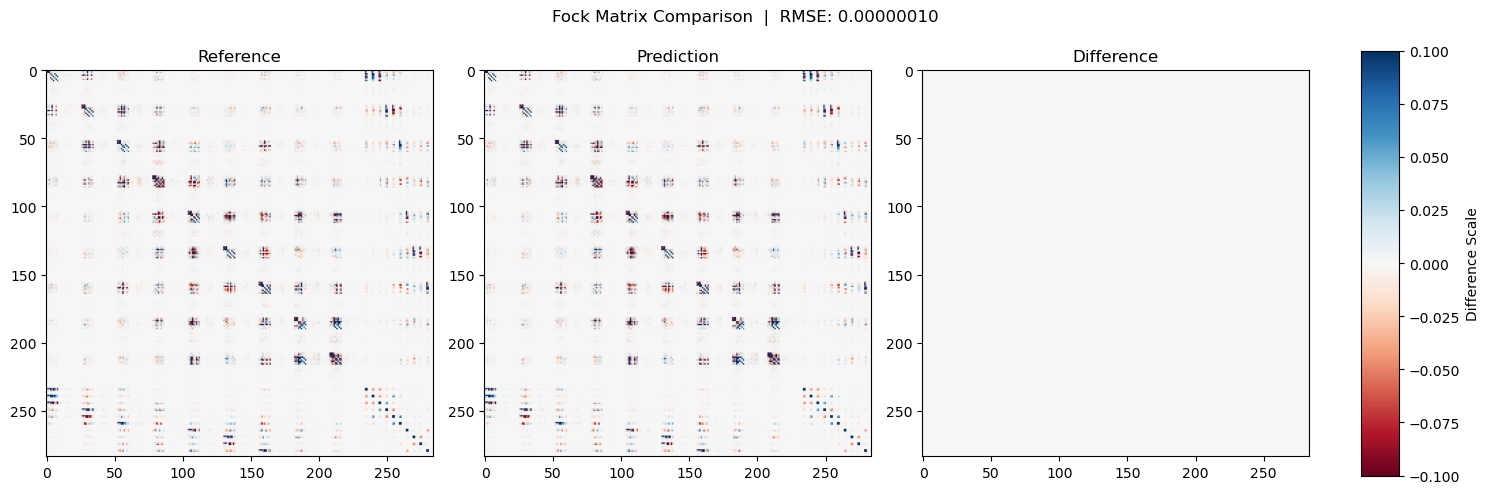

In [48]:
for key in dataset.test_keys:
    print(key)
    sol_sample = dataset.solution(key)
    mol = dataset.molecule(key)
    mf = create_mf_from_mol(mol, xc="b3lypg")
    fock_ = build_fock_from_density(mf, pred_density)
    eigvals, eigvecs = np.linalg.eig(fock_)
    fock_diagonalized = np.diag(eigvals)
    fock_diagonalized = eigvecs @ fock_diagonalized @ np.linalg.inv(eigvecs)
    # plot_mat_comp(sol_sample.fock, fock_, vmax=0.1)
    density_from_diag_fock = density_from_fock(sol_sample.fock, sol_sample.overlap, mol.nelectron//2)
    plot_mat_comp(sol_sample.density, density_from_diag_fock, vmax=0.1)
    break